# ✏️ Esercizi

Stiamo studiando la relazione tra la grandezza del cervello e il Quoziente d'Intelligenza (Full Scale Intelligence Quotient, FSIQ) in un gruppo di studenti universitari. I dati provengono da uno studio che ha utilizzato scansioni MRI per misurare la grandezza del cervello. 

Riporto qui sotto la descrizione del set di dati.

> The data are based on a study by Willerman et al. (1991) of the relationships between brain size, gender, and intelligence. The research participants consisted of 40 right-handed introductory psychology students with no history of alcoholism, unconsciousness, brain damage, epilepsy, or heart disease who were selected from a larger pool of introductory psychology students with total Scholastic Aptitude Test Scores higher than 1350 or lower than 940. The students in the study took four subtests (Vocabulary, Similarities, Block Design, and Picture Completion) of the Wechsler (1981) Adult Intelligence Scale-Revised. Among the students with Wechsler full-scale IQ’s less than 103, 10 males and 10 females were randomly selected. Similarly, among the students with Wechsler full-scale IQ’s greater than 130, 10 males and 10 females were randomly selected, yielding a randomized blocks design. MRI scans were performed at the same facility for all 40 research participants to measure brain size. The scans consisted of 18 horizontal MRI images. The computer counted all pixels with non-zero gray scale in each of the 18 images, and the total count served as an index for brain size. The dataset and description are adapted from the Data and Story Library (DASL) website.

In questa analisi, ci concentreremo sui dati relativi ai maschi, cercando di capire se vi è una associazione positiva tra la grandezza del cervello (MRI) e il FSIQ. Si usi un'analisi di regressione con FSIQ come variabile dipendente e MRI come predittore.

Si trovi la distribuzione a posteriori del parametro $\beta$. (a) Si trovi l'intervallo di credibilità a posteriodi HDI al 95% per $\beta$. (b) Si trovi la probabilità a posteriori che $\beta$ sia positivo. (c) Si interpretino i risultati.

Prima di eseguire l'analisi di regressione, si standardizzino i dati.

## Soluzione

In [19]:
import pymc as pm
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

# Impostazione del seme per la riproducibilità
np.random.seed(84735)

In [28]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [20]:
brain_data = pd.read_csv("../data/brain_data.csv")
brain_data.head()

,ID,GENDER,FSIQ,VIQ,PIQ,MRI,IQDI
0,2,Male,140,150,124,1001121,Higher IQ
1,3,Male,139,123,150,1038437,Higher IQ
2,4,Male,133,129,128,965353,Higher IQ
3,9,Male,89,93,84,904858,Lower IQ
4,10,Male,133,114,147,955466,Higher IQ


In [21]:
# Filtraggio dei dati per i maschi
males = brain_data[brain_data['GENDER'] == 'Male']
males.shape

(20, 7)

In [22]:
# Standardizzazione di MRI e FSIQ
males['fsiq'] = (males['FSIQ'] - males['FSIQ'].mean()) / males['FSIQ'].std()
males['mri'] = (males['MRI'] - males['MRI'].mean()) / males['MRI'].std()

/var/folders/hl/dt523djx7_q7xjrthzjpdvc40000gn/T/ipykernel_61586/2956472145.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  males['fsiq'] = (males['FSIQ'] - males['FSIQ'].mean()) / males['FSIQ'].std()
/var/folders/hl/dt523djx7_q7xjrthzjpdvc40000gn/T/ipykernel_61586/2956472145.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  males['mri'] = (males['MRI'] - males['MRI'].mean()) / males['MRI'].std()


<Axes: xlabel='mri', ylabel='fsiq'>

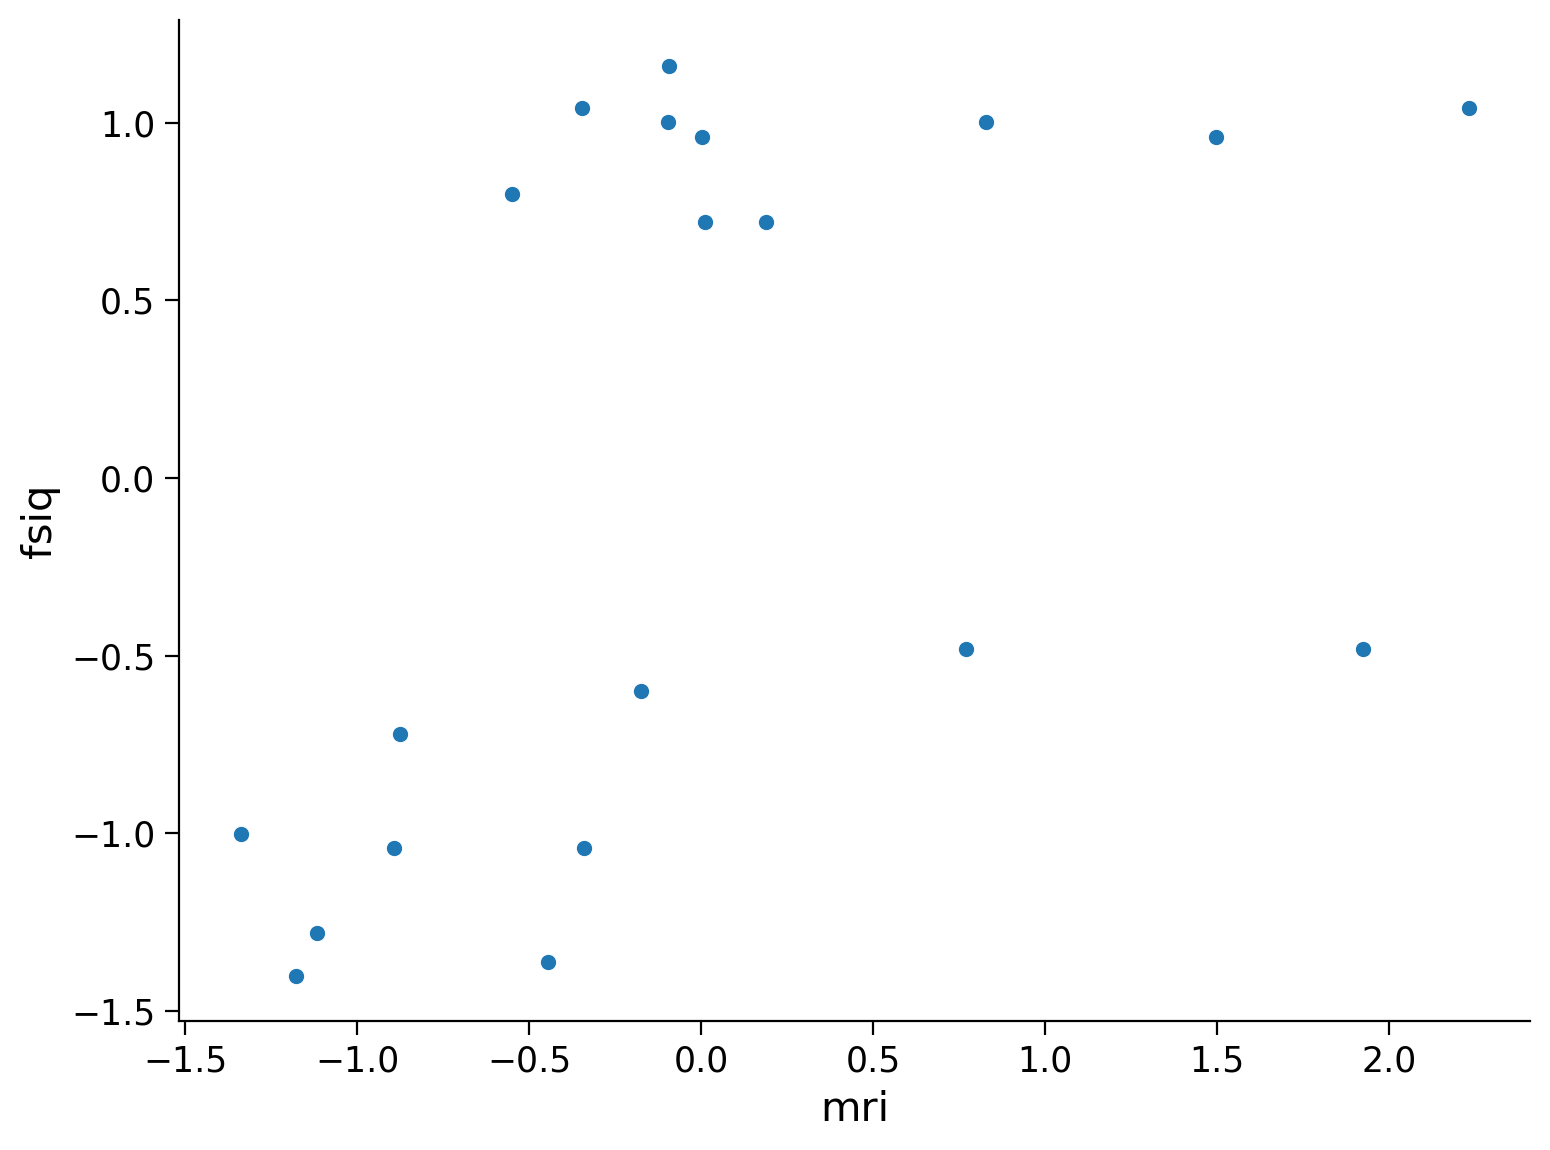

In [29]:
# Diagramma a dispersione
sns.scatterplot(data=males, x='mri', y='fsiq')

In [24]:
# Dati per il modello
data = {
    'N': len(males['fsiq']),
    'x': males['mri'].values,
    'y': males['fsiq'].values
}

df = pd.DataFrame(data)
df.head()

,N,x,y
0,20,0.827481,1.000548
1,20,1.494895,0.960526
2,20,0.187754,0.720394
3,20,-0.894226,-1.040570
4,20,0.010921,0.720394


In [25]:
# Definizione del modello
with pm.Model() as model:
    alpha = pm.Normal("alpha", 0, 2.5)
    beta = pm.Normal("beta", 0, 2.5)
    sigma = pm.HalfNormal("sigma", 10)
    mu = alpha + beta * data["x"]
    y_obs = pm.Normal("y_obs", mu, sigma, observed=data["y"])

In [15]:
with model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


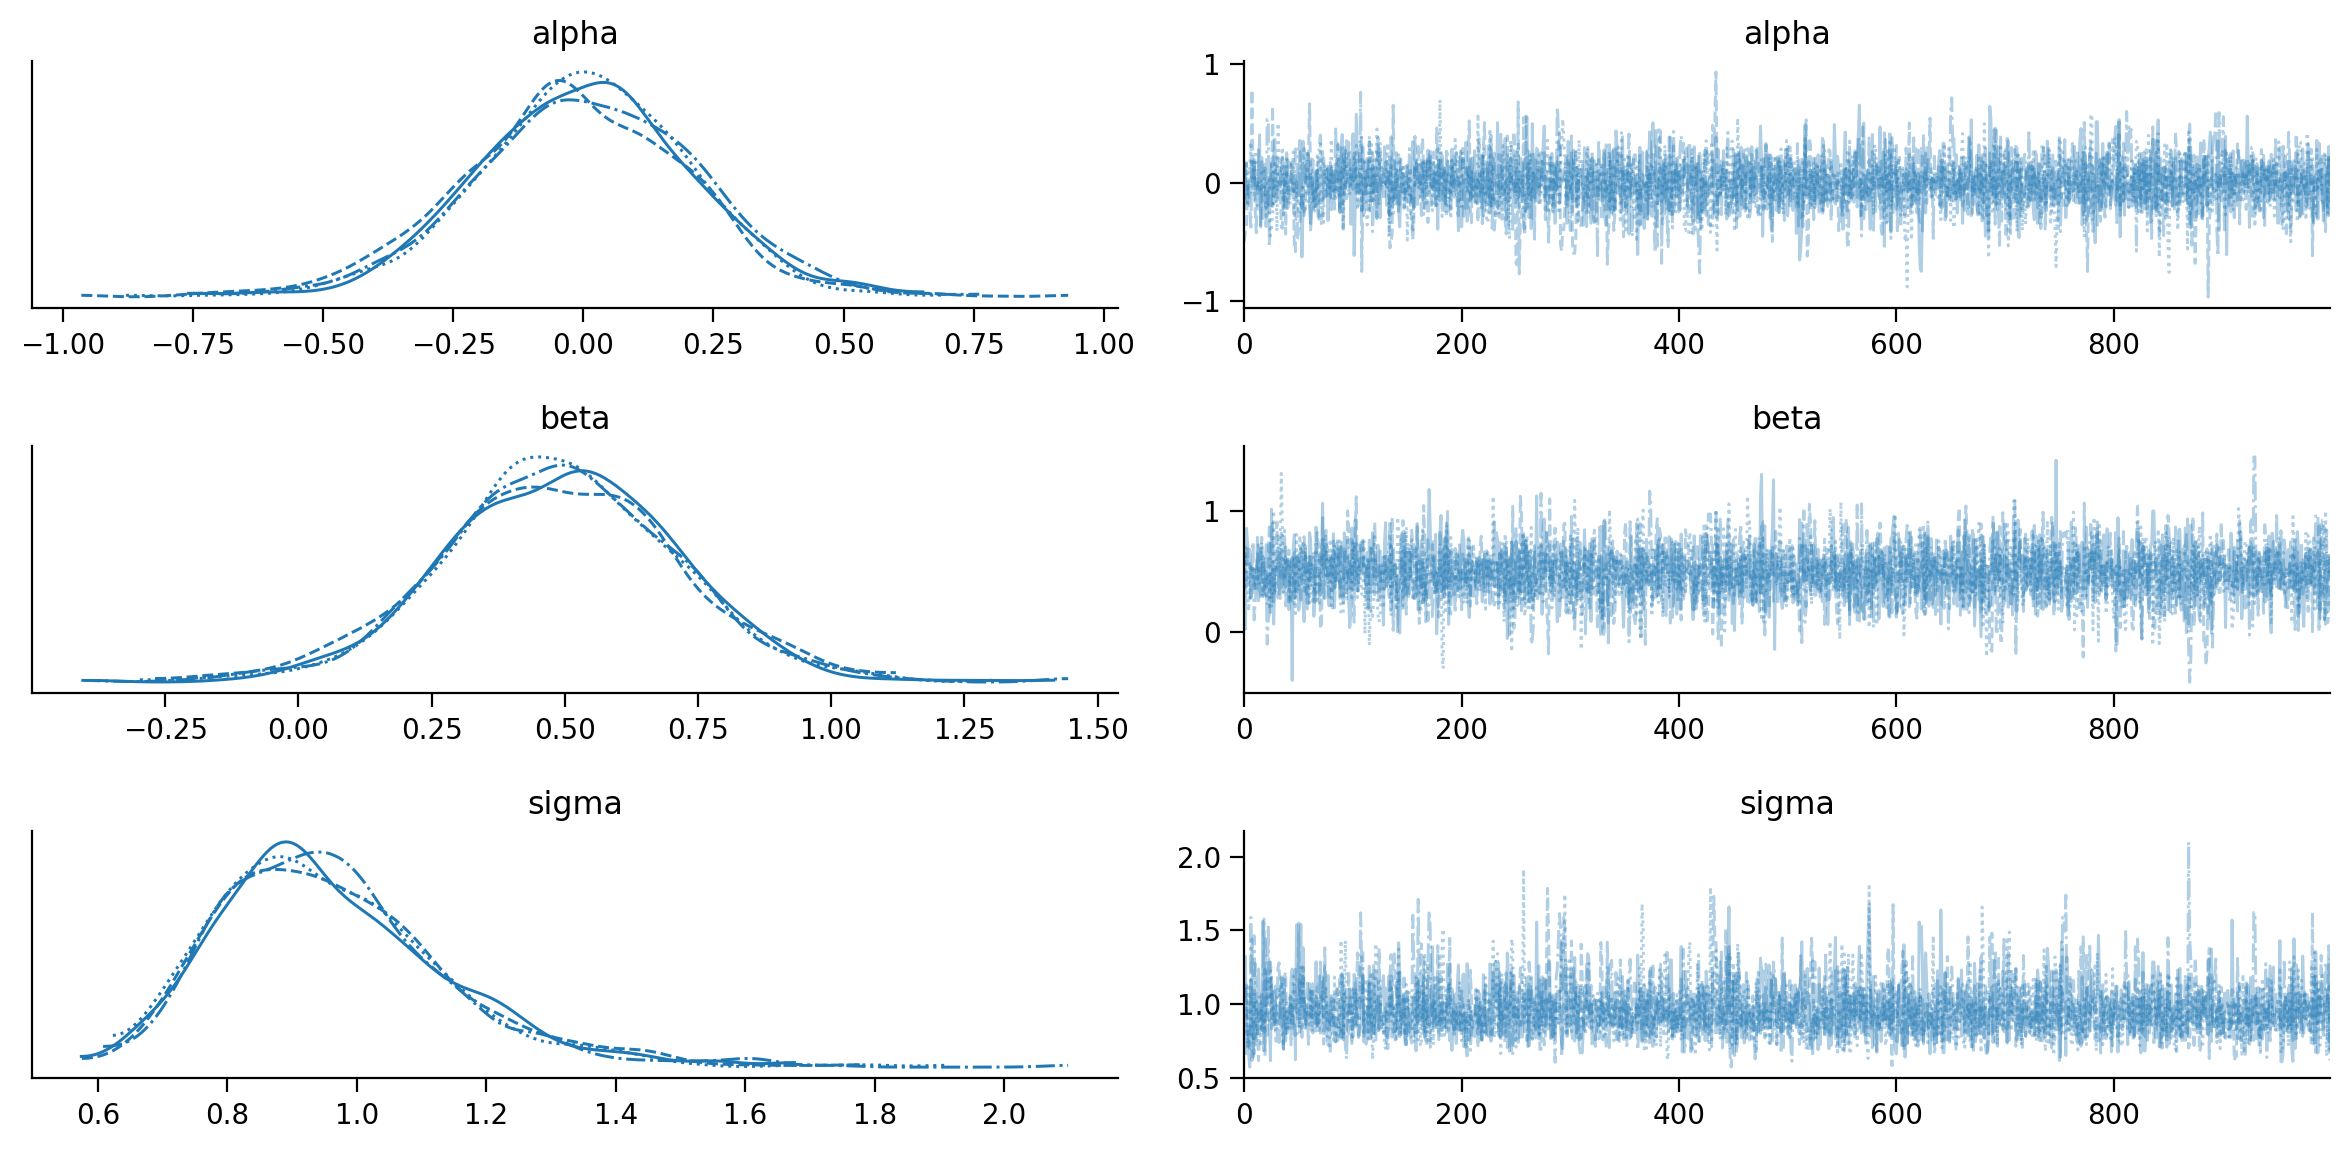

In [30]:
# Diagnostica
az.plot_trace(idata);

In [32]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.00,0.21,-0.41,0.38,0.0,0.0,3629.37,2300.45,1.0
beta,0.49,0.22,0.11,0.92,0.0,0.0,3937.10,2949.08,1.0
sigma,0.96,0.18,0.66,1.29,0.0,0.0,3443.34,2681.68,1.0


In [33]:
az.hdi(idata, hdi_prob=0.95)

<xarray.Dataset>
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 'lower' 'higher'
Data variables:
    alpha    (hdi) float64 -0.434 0.3922
    beta     (hdi) float64 0.06583 0.9248
    sigma    (hdi) float64 0.6602 1.324

In [36]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [37]:
# Probabilità che beta sia maggiore di 0
prob_beta_positive = (idata.posterior["beta"] > 0).mean()
print("Probabilità che beta sia maggiore di 0:", prob_beta_positive)

Probabilità che beta sia maggiore di 0: <xarray.DataArray 'beta' ()>
array(0.98475)


array([<Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'beta'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

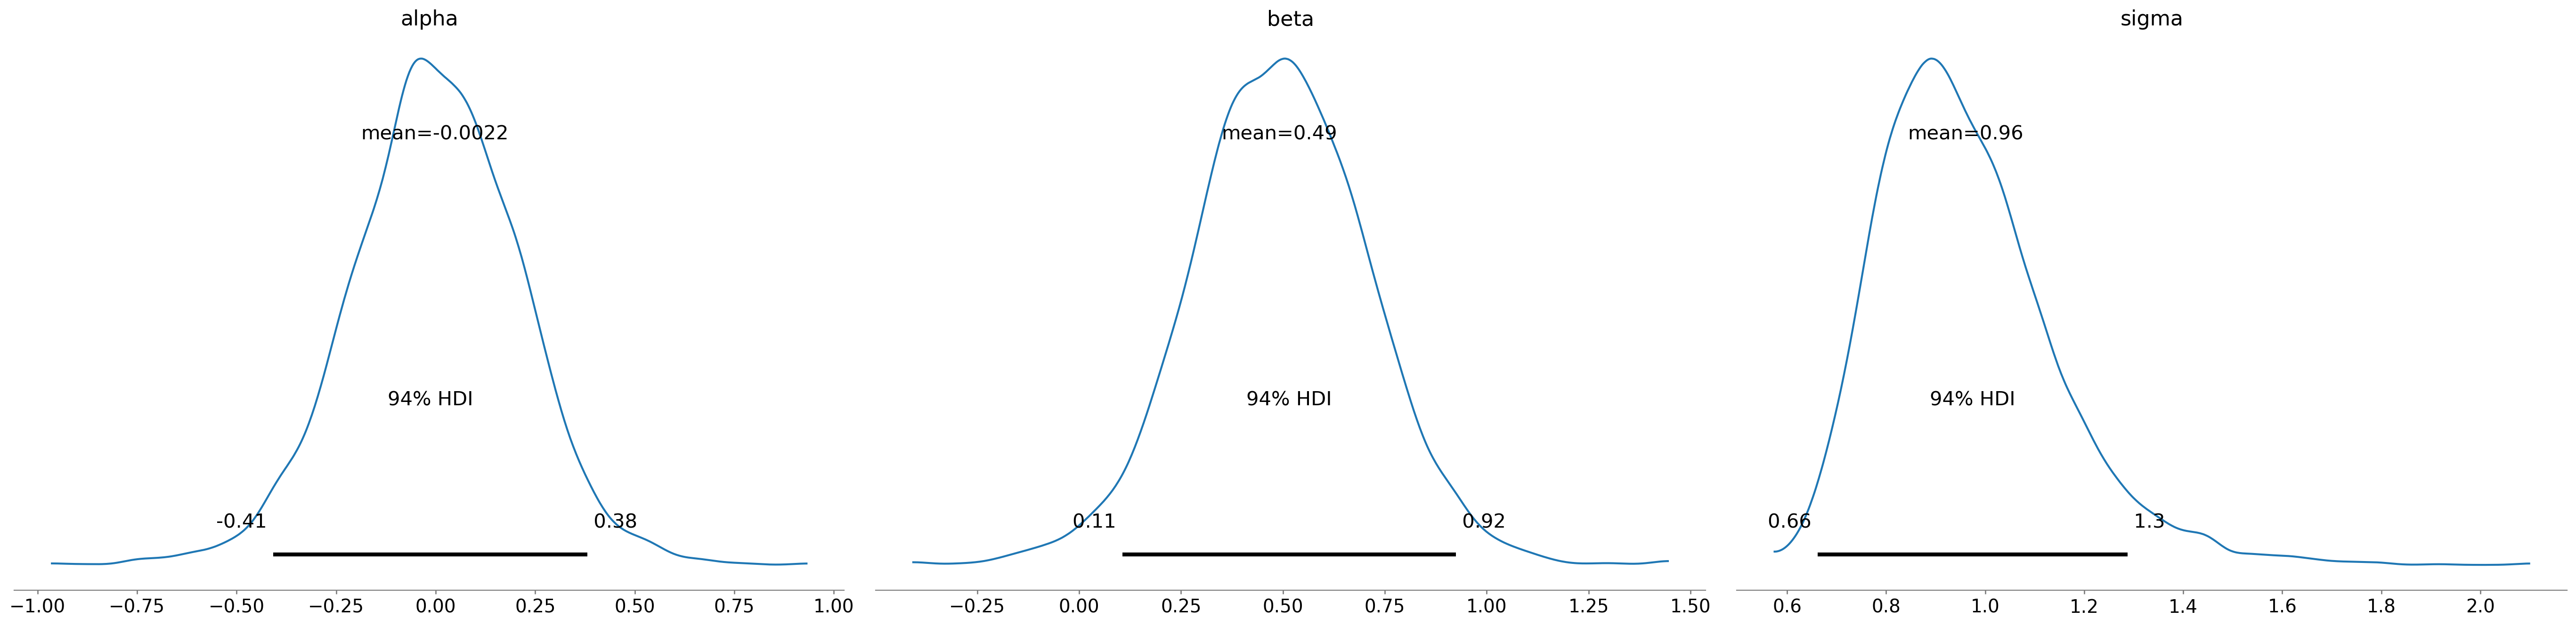

In [38]:
# Grafico della distribuzione a posteriori dei parametri
az.plot_posterior(idata, round_to=2)

## Conclusioni

Analizzando i dati, troviamo evidenze che, nei maschi, la grandezza del cervello, così come indicizzata dagli scan MRI, è positivamente associata al FSIQ. In particolare, un aumento di una deviazione standard nella grandezza del cervello, così com'è stata misurata nel presente studio, corrisponde a un aumento medio nel FSIQ di un valore proporzionale alla stima del parametro $\beta$. Gli intervalli di credibilità possono essere utilizzati per quantificare l'incertezza associata a questa stima.

Questi risultati supportano l'idea che vi sia una relazione positiva tra la grandezza del cervello e l'intelligenza, almeno in questo specifico campione di maschi. Tuttavia, è importante notare che questi risultati non dimostrano una relazione causale, e ulteriori ricerche potrebbero essere necessarie per comprendere pienamente la natura di questa associazione.